In [1]:
%run Text_Preprocessing.ipynb
%run Validation_and_Testing.ipynb

Documentation:
1. Converted class label to categorical
2. Supplied (original) vectorisers + TF-IDF vectorizer
3. Added preprocessing (punctuation removal, casefolding, stop-words removal (including words to short), lemmatization) steps to the text features
4. Encoded the simple string features ('Authors', 'Publisher', 'Language')
5. Dimensionality reduction with TruncatedSVD
6. Bigrams instead of words
7. Feature selection with SelectKBest
8. Standardization of 'pageNumbers' 
9. Instead of 8: Take the log of the standardized 'pageNumbers' using MinMaxScaler

Yet to try:
* Discretisation of PageNumbers

In [2]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import scipy
import re
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Load datasets
original_train_df = pd.read_csv(r"book_rating_train.csv", index_col = False, delimiter = ',', header=0)
original_test_df = pd.read_csv(r"book_rating_test.csv", index_col = False, delimiter = ',', header=0)
print("Training set size:", len(original_train_df))
print("Test set size:", len(original_test_df))

Training set size: 23063
Test set size: 5766


In [5]:
train_df = original_train_df.copy()
test_df = original_test_df.copy()

# 1. Preprocessing

In [6]:
STRING_FEATURES = ['Authors', 'Publisher', 'Language']  # categorical features
NUMERICAL_FEATURES = ['PublishYear', 'PublishMonth', 'PublishDay', 'pagesNumber']
TEXT_FEATURES = ['Name', 'Description']
CLASS_LABEL = 'rating_label'

In [7]:
# Check class distributions
class_labels, counts = np.unique(original_train_df[CLASS_LABEL], return_counts=True)
for label, count in zip(class_labels, counts):
    print(f"Rating {label}: {count} instances")

Rating 3.0: 5864 instances
Rating 4.0: 16208 instances
Rating 5.0: 991 instances


## Preprocess String features: Language, Authors, and Publisher

In [8]:
for feature in STRING_FEATURES:
    print(f"There are {original_train_df[feature].nunique()} unique '{feature}' values.")
    print(f"There are {original_train_df[feature].isna().sum()} missing '{feature}' values.\n")

# Too many missing values in 'Language'. Let's drop this feature.
train_df = train_df.drop('Language', axis=1)

There are 16301 unique 'Authors' values.
There are 0 missing 'Authors' values.

There are 4247 unique 'Publisher' values.
There are 148 missing 'Publisher' values.

There are 18 unique 'Language' values.
There are 17202 missing 'Language' values.



In [9]:
# For Authors and Publisher, we just do a general text preprocessing here
# The models will later choose their own version of preprocessed dataset
CATEGORICAL_FEATURES = ['Authors', 'Publisher']
entire_df = pd.concat([train_df, test_df])

for df in [train_df, entire_df]:
    for feature in CATEGORICAL_FEATURES:
        df[feature] = df[feature].apply(lambda x: preprocess(str(x), stop_words_removal=False, lemmatize=False, min_word_len=0))

### Option 1: One-Hot Encoder

In [10]:
from sklearn.preprocessing import OneHotEncoder

OHE = OneHotEncoder(handle_unknown='infrequent_if_exist', min_frequency=5, max_categories=300, sparse=False)
OHE.fit(entire_df[CATEGORICAL_FEATURES])

OneHotEncoder(handle_unknown='infrequent_if_exist', max_categories=300,
              min_frequency=5, sparse=False, sparse_output=False)

In [139]:
def ohe_transform(df):
    transformed_mat = OHE.transform(df[CATEGORICAL_FEATURES])
    transformed_cat_df = pd.DataFrame(transformed_mat).set_axis(OHE.get_feature_names_out(), axis=1, inplace=False)
    transformed_df = pd.concat([df.reset_index(drop=True), transformed_cat_df], axis=1)
    transformed_df = transformed_df.drop(CATEGORICAL_FEATURES, axis=1)  # drop the original attributes
    return transformed_df

### Option 2: Ordinal Encoder

In [12]:
from sklearn.preprocessing import OrdinalEncoder

ORD_ENCODER = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
ORD_ENCODER.fit(entire_df[CATEGORICAL_FEATURES])

OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

In [13]:
def ord_enc_transform(df):
    df = df.copy()
    df[CATEGORICAL_FEATURES] = ORD_ENCODER.transform(df[CATEGORICAL_FEATURES])
    for i in range(len(CATEGORICAL_FEATURES)):  
        # some models (e.g. CategoricalNB), cannot handle negative values, so we replace -1 with the next unused int to denote unseen values
        df[CATEGORICAL_FEATURES[i]] = df[CATEGORICAL_FEATURES[i]].replace(-1, ORD_ENCODER.categories_[i].size)
    
    return df

## Preprocess Numerical features: PublishDates and pagesNumber

### Data Visualisation

In [200]:
# Look at NMI of the numerical attributes
train_numerical_df = original_train_df[NUMERICAL_FEATURES]
train_label = original_train_df[CLASS_LABEL]

for feature in NUMERICAL_FEATURES:
    print(f"NMI for {feature} =", normalized_mutual_info_score(train_numerical_df[feature], train_label.astype('category')))

NMI for PublishYear = 0.005010413368619569
NMI for PublishMonth = 0.0007191125502055215
NMI for PublishDay = 0.0013529681241697595
NMI for pagesNumber = 0.01964529722439041


In [198]:
from sklearn.feature_selection import chi2

num_features_chi2_pval = {}
for feature in original_train_df[NUMERICAL_FEATURES]:
    num_features_chi2_pval[feature] = chi2(train_numerical_df[[feature]], train_label.astype('category'))[1] 
pd.DataFrame.from_dict(num_features_chi2_pval)

,PublishYear,PublishMonth,PublishDay,pagesNumber
0,0.066846,0.631445,2.654705e-24,0.0


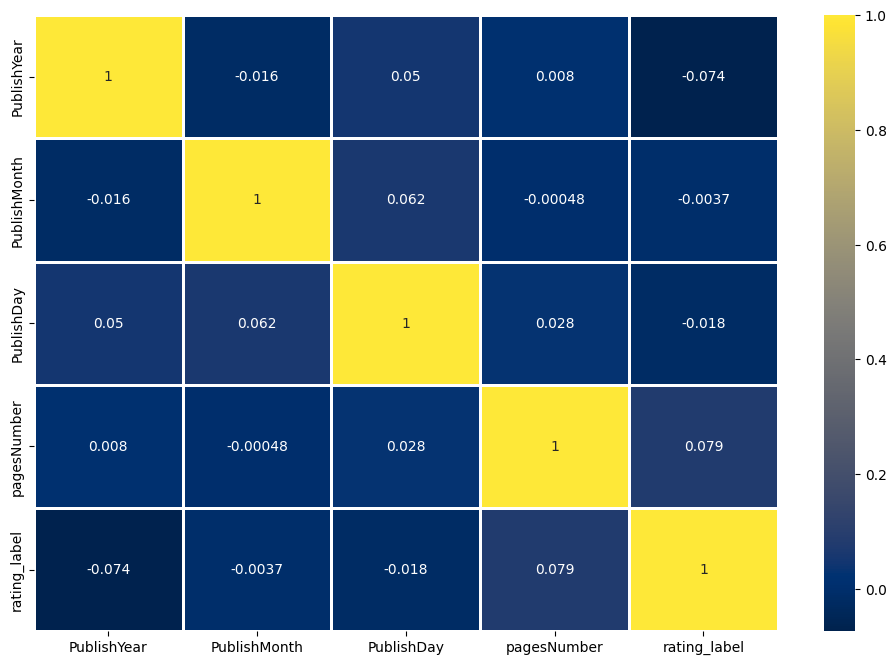

In [15]:
# Look at the correlation matrix of the numerical attributes
cor_matrix = train_df[NUMERICAL_FEATURES + [CLASS_LABEL]].corr()
round(cor_matrix, 2)
plt.figure(figsize=(12, 8))
sns.heatmap(cor_matrix, cmap='cividis', annot=True, linewidths=2)
plt.show()

In [ ]:
# NMI: top 2 = PublishYear, pagesNumber
# Chi2: top 2 = PublishDay, pagesNumber
# Correlation matrix: top 2 = PublishYear, pagesNumber

In [16]:
def scatter_vs_rating(df, feature):
    plt.scatter(df[feature], df[CLASS_LABEL])
    plt.xlabel(feature)
    plt.ylabel('rating')

In [17]:
def hist_plot(df, feature, bins=30):
    plt.hist(df[feature], bins=bins)
    plt.xlabel(feature)
    plt.ylabel('frequency')
    plt.show()

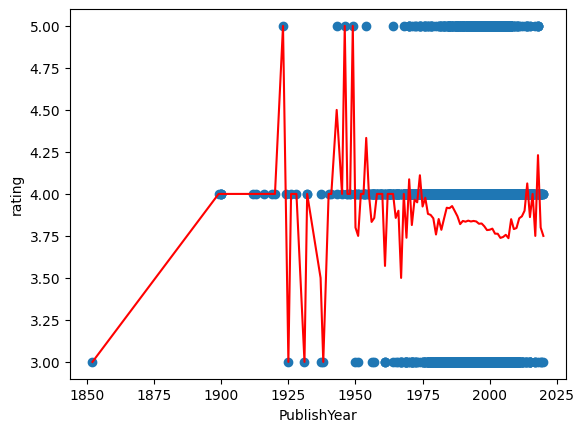

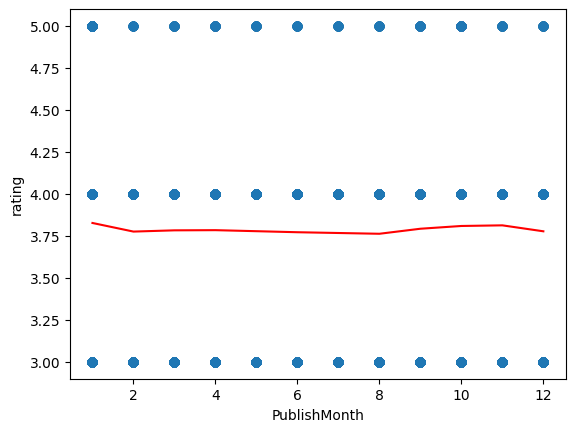

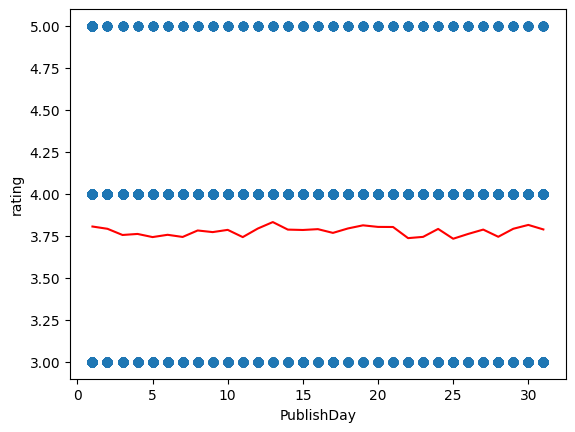

In [18]:
# Scatterplots for Publish year, month, and day vs. Rating
for feature in ['PublishYear', 'PublishMonth', 'PublishDay']: 
    scatter_vs_rating(train_df, feature)
    
    # Look at the average rating for each value
    values, counts = np.unique(sorted(train_df[feature]), return_counts=True)
    avg = [sum(train_df.loc[train_df[feature] == values[i]][CLASS_LABEL]) / counts[i] for i in range(len(values))]
    plt.plot(values, avg, color = 'red')
    plt.show()

In [19]:
# Looks like there's little correlation between the Publish time and rating_label
# Let's discard PublishMonth and PublishDay
train_df = train_df.drop(['PublishMonth', 'PublishDay'], axis=1)

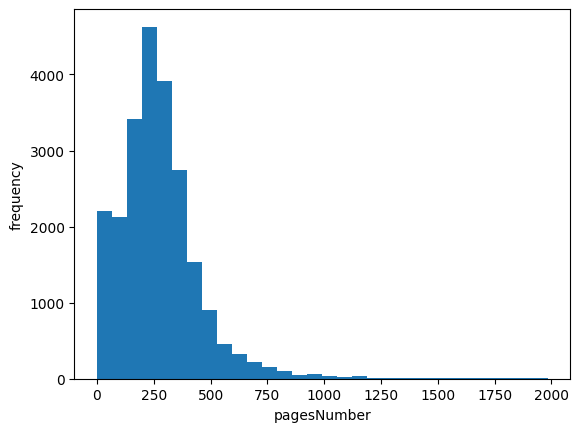

In [20]:
# Histogram for pages number < 2000
hist_plot(train_df.loc[train_df['pagesNumber'] < 2000], 'pagesNumber')

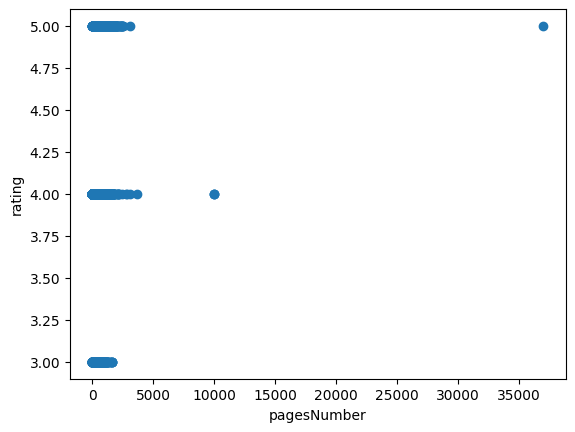

In [21]:
scatter_vs_rating(train_df, 'pagesNumber')
plt.show()

In [22]:
# Try discretizing it
from sklearn.preprocessing import KBinsDiscretizer

def discretize(df, feature, discretizer=None, strategy='kmeans', n_bins=7):
    if discretizer is None:
        discretizer = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy=strategy)
        discretizer.fit(df[[feature]])
        
    transformed_df = df.copy()
    transformed_df[feature] = discretizer.transform(df[[feature]])
    
    return transformed_df, discretizer

In [23]:
DISCRETIZATION_STRATEGIES = ['kmeans', 'quantile', 'uniform']

def tune_discretization(X, y, feature, lower, upper):
    """
    Returns the combination of n (number of bins) and discretisation strategy 
    that gives the highest normalised mutual information between `X` and `y`.
    """
    
    max_nmi = 0
    best_n = 0
    best_strategy = None
    
    for n in range(lower, upper+1):
        for strategy in DISCRETIZATION_STRATEGIES:
            transformed_X, _ = discretize(X, feature, strategy=strategy, n_bins=n)
            nmi = normalized_mutual_info_score(transformed_X[feature], y)
            if nmi > max_nmi:
                max_nmi = nmi
                best_n = n
                best_strategy = strategy
    
    return max_nmi, best_n, best_strategy

In [24]:
max_nmi_pn, best_n_pn, best_strategy_pn = tune_discretization(train_numerical_df, train_label, 'pagesNumber', 2, 20)
print("The number of bins that gives the highest NMI with rating_label is", best_n_pn)
print("The highest NMI is:", max_nmi_pn)
print("The best strategy is:", best_strategy_pn)

The number of bins that gives the highest NMI with rating_label is 7
The highest NMI is: 0.013006785743756806
The best strategy is: kmeans


In [25]:
train_df, discretizer_pn = discretize(train_df, 'pagesNumber', strategy='kmeans', n_bins=7)
np.unique(train_df['pagesNumber'], return_counts=True)

(array([0., 1., 2., 3., 4., 5., 6.]),
 array([ 7578, 10024,  4422,   917,   118,     3,     1]))

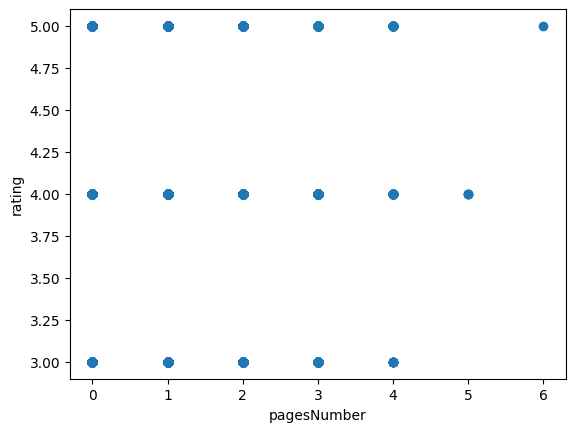

In [26]:
scatter_vs_rating(train_df, 'pagesNumber')

In [27]:
# Try discretizing PublishYear as well 
max_nmi_py, best_n_py, best_strategy_py = tune_discretization(train_numerical_df, train_label, 'PublishYear', 2, 100)
print("The number of bins that gives the highest NMI with rating_label is", best_n_py)
print("The highest NMI is:", max_nmi_py)
print("The best strategy is:", best_strategy_py)

The number of bins that gives the highest NMI with rating_label is 15
The highest NMI is: 0.006425277331391137
The best strategy is: uniform


In [28]:
train_df, discretizer_py = discretize(train_df, 'PublishYear', strategy='uniform', n_bins=15)
np.unique(train_df['PublishYear'], return_counts=True)

(array([ 0.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14.]),
 array([    1,     5,     4,     6,     8,    19,    59,   233,  1080,
         5058, 16219,   371]))

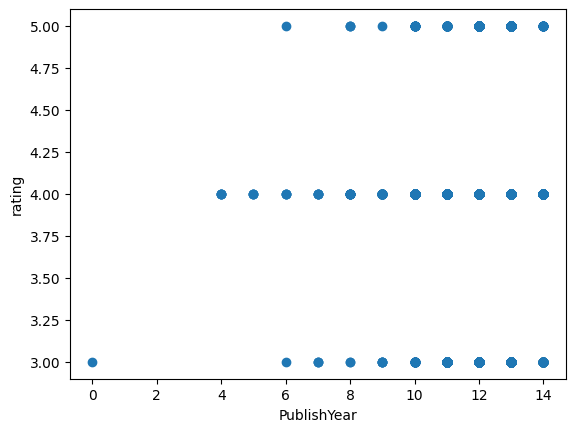

In [29]:
scatter_vs_rating(train_df, 'PublishYear')

## Text Pre-processing

In [30]:
# We use a different delimiter for the name and description bigrams, to prevent duplicate column namaes
train_df_name, vectorizer_name = preprocess_text_feature(train_df, 'Name', ngram=2, delimiter='_')  # can try ngram=1
train_df_desc, vectorizer_desc = preprocess_text_feature(train_df, 'Description', ngram=2)
# print(sorted(vectorizer_name.vocabulary_))
# print(sorted(vectorizer_desc.vocabulary_))

In [31]:
# Bind them together
train_df = pd.concat([train_df.reset_index(drop=True), train_df_name, train_df_desc], axis=1)
train_df = train_df.drop(TEXT_FEATURES, axis=1)  # drop the original columns

## Convert rating_label to categorical class label

In [32]:
# Finally, convert rating_label to categorical class label
train_df[CLASS_LABEL] = train_df[CLASS_LABEL].astype('category')
# move rating_label to the last column
labels = train_df[CLASS_LABEL]
train_df = pd.concat([train_df.drop([CLASS_LABEL], axis=1), labels], axis=1) 

In [33]:
DTYPE = train_df.dtypes.apply(lambda x: x.name).to_dict()  # needed for reading the CSV later
DTYPE['Authors'] = 'string'
DTYPE['Publisher'] = 'string'

In [34]:
# Save the general transformed df
train_df.to_csv("transformed_train_df.csv", index=False)

## Preprocessing: Altogether

In [35]:
def preprocess_test_df(df, discretizer_pn=None, discretizer_py=None, vectorizer_name=None, vectorizer_desc=None):
    df = df.copy()
    
    # preprocess string features
    for feature in CATEGORICAL_FEATURES:
        df[feature] = df[feature].apply(lambda x: preprocess(str(x), stop_words_removal=False, lemmatize=False, min_word_len=0))
    
    # preprocess pagesNumber and PublishYear
    df, _ = discretize(df, 'pagesNumber', discretizer=discretizer_pn)
    df, _ = discretize(df, 'PublishYear', discretizer=discretizer_py)
    
    # preprocess text features
    df_name, _ = preprocess_text_feature(df, 'Name', vectorizer=vectorizer_name, delimiter='_')
    df_desc, _ = preprocess_text_feature(df, 'Description', vectorizer=vectorizer_desc)
    
    # discard the obsolete original features and some unwanted features
    df = pd.concat([df.reset_index(drop=True), df_name, df_desc], axis=1)
    df = df.drop(['Name', 'Description', 'PublishMonth', 'PublishDay', 'Language'], axis=1)
        
    return df, discretizer_pn, discretizer_py, vectorizer_name, vectorizer_desc

In [36]:
test_df = preprocess_test_df(original_test_df, discretizer_pn, discretizer_py, vectorizer_name, vectorizer_desc)[0]
test_df.to_csv("transformed_test_df.csv", index=False)
test_df

,Authors,PublishYear,Publisher,pagesNumber,reading_writing,gay_lesbian,secret_life,travel_guide,seventeenth_century,best_practice,...,love affair,north america,paperback edition,book cover,book one,family life,civil right,step instruction,young girl,everything need
0,richard rohr,12.0,orbis books,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,robert blake,12.0,puffin,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,martha taylor,13.0,benjamin cummings,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,beverley,13.0,signet,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,michele kort,13.0,thomas dunne books,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.301431,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5761,jamie martinez wood,13.0,ten speed press,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5762,myra nour,13.0,ellora cave,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5763,jos silva,13.0,editorial diana,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5764,erwin panofsky,10.0,westview press,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Model Induction on Training set

In [116]:
train_full_df = train_df.copy()  # full training set

In [117]:
# Train-validation split
train_df, val_df = train_test_split(train_full_df, train_size=0.8, random_state=30027)
val_df

,Authors,PublishYear,Publisher,pagesNumber,reading_writing,gay_lesbian,secret_life,travel_guide,seventeenth_century,best_practice,...,north america,paperback edition,book cover,book one,family life,civil right,step instruction,young girl,everything need,rating_label
17657,dana fuller ross,13.0,bantam,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,4.0
2667,karen robards,13.0,signet,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,4.0
8711,michael roberts,13.0,faber faber,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,4.0
22915,clifford green,12.0,augsburg fortress publishing,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,4.0
13197,gerd gigerenzer,13.0,simon schuster,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17547,james patterson,13.0,turtleback books,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.449643,0.0,0.49095,0.0,0.0,0.0,0.0,0.0,0.0,4.0
4545,akihito toda,13.0,nan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,5.0
4792,william reese,12.0,humanity books,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,4.0
21636,barbara hodgson,13.0,greystone books,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,4.0


In [142]:
# training set
X_train = train_df.iloc[:,:-1] # (transformed) attributes
y_train = train_df.iloc[:,-1]  # ground truth labels
# validation set
X_val = val_df.iloc[:,:-1]
y_val = val_df.iloc[:,-1]

X_train_ohe = ohe_transform(X_train)
X_train_oe = ord_enc_transform(X_train)
X_val_ohe = ohe_transform(X_val)
X_val_oe = ord_enc_transform(X_val)

In [143]:
X_train_ohe

,PublishYear,pagesNumber,reading_writing,gay_lesbian,secret_life,travel_guide,seventeenth_century,best_practice,next_generation,delicious_recipe,...,Publisher_wizards the coast,Publisher_workman publishing company,Publisher_writer digest books,Publisher_yale university press,Publisher_yearling,Publisher_zebra,Publisher_zondervan,Publisher_zondervan academic,Publisher_zondervan publishing company,Publisher_infrequent_sklearn
0,13.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,13.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,13.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,13.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,13.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14755,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14756,12.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14757,12.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14758,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [144]:
ORDINAL_FEATURES = ['PublishYear', 'pagesNumber']
CATEGORICAL_FEATURES = ['Authors', 'Publisher']
TEXT_FEATURES = list(X_train.columns)[4:]

## Naive Bayes

In [145]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB, CategoricalNB

In [146]:
# Split the training set for each Naive Bayes base classifier
X_train_gaussian = X_train_oe[ORDINAL_FEATURES]
X_val_gaussian = X_val_oe[ORDINAL_FEATURES]
X_train_categorical = X_train_oe[CATEGORICAL_FEATURES]
X_val_categorical = X_val_oe[CATEGORICAL_FEATURES]
X_train_multinomial = X_train_oe[TEXT_FEATURES]
X_val_multinomial = X_val_oe[TEXT_FEATURES]

### Gaussian NB for PublishYear and pagesNumber

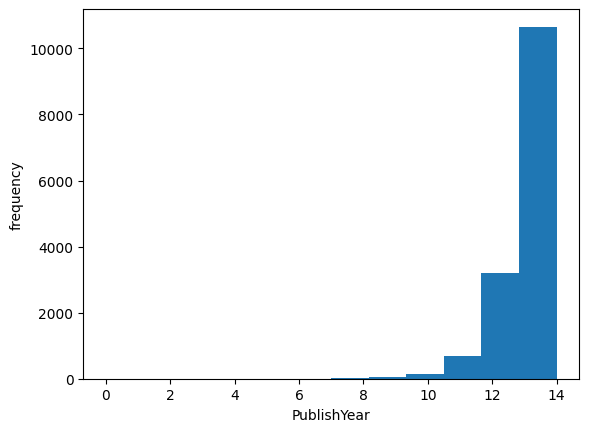

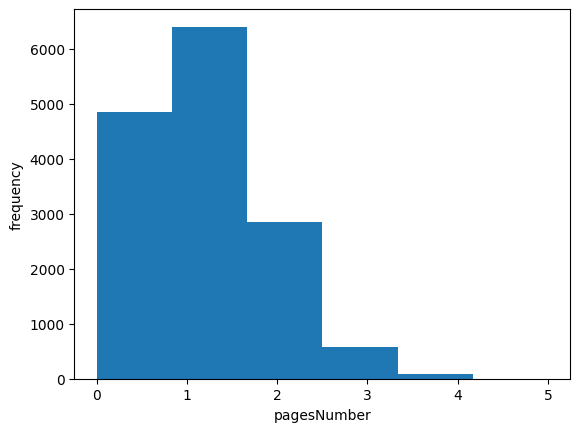

In [147]:
# check distribution of PublishYear and pagesNumber
for feature in ORDINAL_FEATURES:
    hist_plot(X_train_oe, feature, bins=X_train_oe[feature].nunique())

Evaluate on training set:

GaussianNB prediction took 0.1707000732421875 seconds
    test_3.0_f1-score  test_4.0_f1-score  test_5.0_f1-score  test_accuracy
0                 0.0           0.821743           0.057143       0.697832
1                 0.0           0.823341           0.114286       0.700542
2                 0.0           0.822115           0.157895       0.699187
3                 0.0           0.824940           0.114286       0.701897
4                 0.0           0.823058           0.162162       0.700542
5                 0.0           0.822400           0.111111       0.699187
6                 0.0           0.824561           0.062500       0.701897
7                 0.0           0.824940           0.114286       0.701897
8                 0.0           0.825219           0.058824       0.701897
9                 0.0           0.821457           0.052632       0.696477
10                0.0           0.824000           0.108108       0.700542
11                0

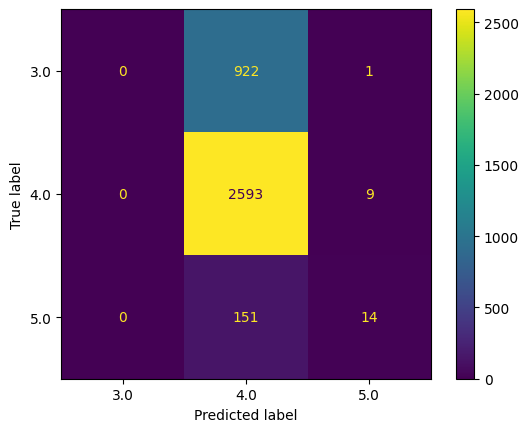

              precision    recall  f1-score   support

         3.0       0.00      0.00      0.00       923
         4.0       0.71      1.00      0.83      2602
         5.0       0.58      0.08      0.15       165

    accuracy                           0.71      3690
   macro avg       0.43      0.36      0.33      3690
weighted avg       0.52      0.71      0.59      3690



In [148]:
gnb = GaussianNB()
gaussian_val_pred = validate_and_test(gnb, X_train_gaussian, y_train, X_val_gaussian, y_val)

### Categorical NB for Authors and Publisher

In [149]:
# Tuning for alpha smoothing
cnb = CategoricalNB(min_categories = [len(ORD_ENCODER.categories_[i]) for i in range(len(CATEGORICAL_FEATURES))])
param_grid = {'alpha': [i/10 for i in range(1, 15)]}
tune_hyperparameter(cnb, param_grid, X_train_categorical, y_train)

# larger alpha -> overestimate the likelihood
# could be because there is more samples with label4 ratings, and the missing values are randomly 
# distributed across the dataset, hence more samples with label4 rating with missing values
# -> likelihood of P(x|c=4) overestimated -> more samples predicted to have label=4

Fitting 20 folds for each of 14 candidates, totalling 280 fits
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END .....................................

[CV] END ..........................................alpha=0.6; total time=   0.0s
[CV] END ..........................................alpha=0.6; total time=   0.0s
[CV] END ..........................................alpha=0.6; total time=   0.0s
[CV] END ..........................................alpha=0.6; total time=   0.0s
[CV] END ..........................................alpha=0.6; total time=   0.0s
[CV] END ..........................................alpha=0.6; total time=   0.0s
[CV] END ..........................................alpha=0.6; total time=   0.0s
[CV] END ..........................................alpha=0.6; total time=   0.0s
[CV] END ..........................................alpha=0.6; total time=   0.0s
[CV] END ..........................................alpha=0.6; total time=   0.0s
[CV] END ..........................................alpha=0.6; total time=   0.0s
[CV] END ..........................................alpha=0.6; total time=   0.0s
[CV] END ...................

[CV] END ..........................................alpha=1.2; total time=   0.0s
[CV] END ..........................................alpha=1.2; total time=   0.0s
[CV] END ..........................................alpha=1.2; total time=   0.0s
[CV] END ..........................................alpha=1.2; total time=   0.0s
[CV] END ..........................................alpha=1.2; total time=   0.0s
[CV] END ..........................................alpha=1.2; total time=   0.0s
[CV] END ..........................................alpha=1.2; total time=   0.0s
[CV] END ..........................................alpha=1.2; total time=   0.0s
[CV] END ..........................................alpha=1.2; total time=   0.0s
[CV] END ..........................................alpha=1.2; total time=   0.0s
[CV] END ..........................................alpha=1.2; total time=   0.0s
[CV] END ..........................................alpha=1.2; total time=   0.0s
[CV] END ...................

,params,mean_test_3.0_f1-score,std_test_3.0_f1-score,rank_test_3.0_f1-score,mean_test_4.0_f1-score,std_test_4.0_f1-score,rank_test_4.0_f1-score,mean_test_5.0_f1-score,std_test_5.0_f1-score,rank_test_5.0_f1-score,mean_test_accuracy,std_test_accuracy,rank_test_accuracy
0,{'alpha': 0.1},0.415530,0.027223,1,0.733314,0.012419,14,0.225620,0.037434,3,0.613957,0.015443,14
1,{'alpha': 0.2},0.400332,0.030862,2,0.761071,0.012745,13,0.292134,0.067355,1,0.651355,0.017448,13
2,{'alpha': 0.3},0.389267,0.035116,3,0.771086,0.013257,12,0.231996,0.073746,2,0.659824,0.018793,12
3,{'alpha': 0.4},0.380284,0.034653,4,0.775453,0.012681,11,0.183120,0.062421,4,0.662669,0.018121,11
4,{'alpha': 0.5},0.368318,0.035365,5,0.777581,0.013041,10,0.173241,0.068573,5,0.663415,0.018282,10
5,{'alpha': 0.6},0.363928,0.036918,6,0.778723,0.012623,9,0.158349,0.075786,6,0.664024,0.017799,9
6,{'alpha': 0.7},0.305288,0.033611,7,0.820295,0.006885,8,0.126935,0.069757,7,0.711856,0.010295,1
7,{'alpha': 0.8},0.291877,0.035439,8,0.820502,0.006328,7,0.124640,0.066120,8,0.711111,0.009880,6
8,{'alpha': 0.9},0.281238,0.035602,9,0.820673,0.006741,6,0.085355,0.051963,9,0.710298,0.010527,8
9,{'alpha': 1.0},0.274320,0.033947,10,0.821669,0.006250,5,0.071974,0.050631,11,0.711043,0.009779,7


Evaluate on training set:

CategoricalNB prediction took 0.25383663177490234 seconds
    test_3.0_f1-score  test_4.0_f1-score  test_5.0_f1-score  test_accuracy
0            0.332155           0.812392           0.000000       0.703252
1            0.319392           0.826531           0.270270       0.722222
2            0.285714           0.810256           0.121212       0.697832
3            0.310078           0.827004           0.121212       0.720867
4            0.265683           0.807198           0.210526       0.692412
5            0.356364           0.826758           0.171429       0.723577
6            0.332046           0.829805           0.166667       0.726287
7            0.311594           0.813036           0.117647       0.703252
8            0.273438           0.817494           0.000000       0.705962
9            0.233871           0.818410           0.060606       0.703252
10           0.320611           0.823729           0.117647       0.718157
11           0.

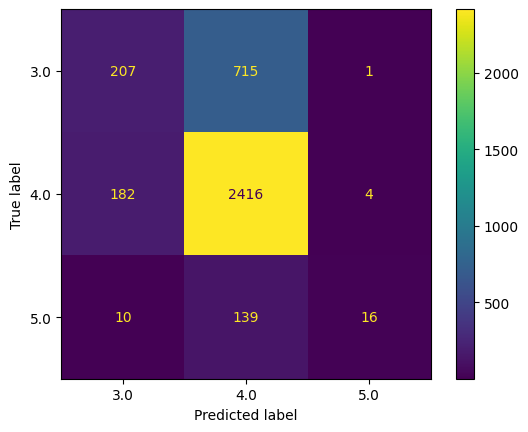

              precision    recall  f1-score   support

         3.0       0.52      0.22      0.31       923
         4.0       0.74      0.93      0.82      2602
         5.0       0.76      0.10      0.17       165

    accuracy                           0.72      3690
   macro avg       0.67      0.42      0.44      3690
weighted avg       0.68      0.72      0.67      3690



In [150]:
cnb = CategoricalNB(alpha=0.7, min_categories = [len(ORD_ENCODER.categories_[i]) for i in range(len(CATEGORICAL_FEATURES))])
categorical_val_pred = validate_and_test(cnb, X_train_categorical, y_train, X_val_categorical, y_val)

### Multinomial NB for Name and Description

Evaluate on training set:

MultinomialNB prediction took 0.6902132034301758 seconds
    test_3.0_f1-score  test_4.0_f1-score  test_5.0_f1-score  test_accuracy
0            0.030612           0.821830           0.058824       0.699187
1            0.049505           0.821918           0.060606       0.699187
2            0.086957           0.822006           0.000000       0.700542
3            0.087805           0.825243           0.114286       0.705962
4            0.058824           0.822959           0.114286       0.700542
5            0.097087           0.824859           0.000000       0.705962
6            0.068966           0.822581           0.060606       0.701897
7            0.087379           0.825525           0.000000       0.704607
8            0.080000           0.822959           0.000000       0.700542
9            0.059701           0.822866           0.060606       0.701897
10           0.029851           0.818402           0.111111       0.693767
11           0.0

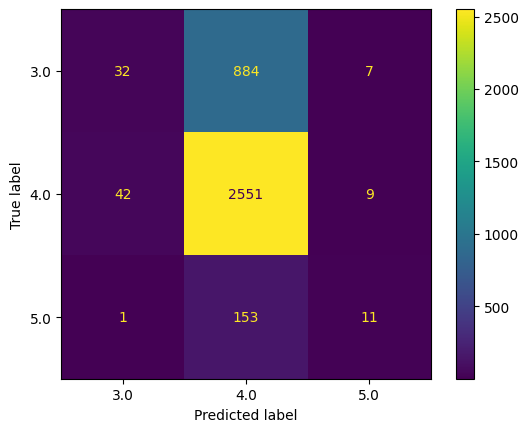

              precision    recall  f1-score   support

         3.0       0.43      0.03      0.06       923
         4.0       0.71      0.98      0.82      2602
         5.0       0.41      0.07      0.11       165

    accuracy                           0.70      3690
   macro avg       0.52      0.36      0.33      3690
weighted avg       0.63      0.70      0.60      3690



In [151]:
# better than complementNB and gaussianNB
mnb = MultinomialNB()
multinomial_val_pred = validate_and_test(mnb, X_train_multinomial, y_train, X_val_multinomial, y_val)

### Categorical NB for final prediction

In [152]:
# CategoricalNB to predict the final rating
# Fit each base model on their training subset
gnb.fit(X_train_gaussian, y_train)
gaussian_train_pred = gnb.predict(X_train_gaussian)
cnb.fit(X_train_categorical, y_train)
categorical_train_pred = cnb.predict(X_train_categorical)
mnb.fit(X_train_multinomial, y_train)
multinomial_train_pred = mnb.predict(X_train_multinomial)

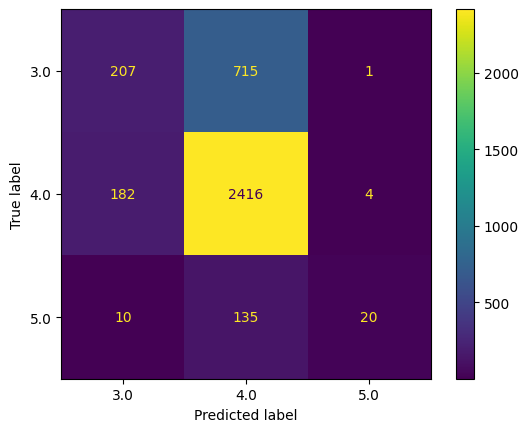

              precision    recall  f1-score   support

         3.0       0.52      0.22      0.31       923
         4.0       0.74      0.93      0.82      2602
         5.0       0.80      0.12      0.21       165

    accuracy                           0.72      3690
   macro avg       0.69      0.42      0.45      3690
weighted avg       0.69      0.72      0.67      3690



array([4., 4., 4., ..., 4., 4., 4.])

In [153]:
X_train_preds = pd.DataFrame({'GaussianNB_Year_Pages' : gaussian_train_pred,
                              'CategoricalNB_Author_Publisher' : categorical_train_pred,
                              'MultinomialNB_Name_Desc' : multinomial_train_pred})

# validation dataframe
X_val_preds = pd.DataFrame({'GaussianNB_Year_Pages' : gaussian_val_pred,
                                'CategoricalNB_Author_Publisher' : categorical_val_pred,
                                'MultinomialNB_Name_Desc' : multinomial_val_pred})

# meta-classifier
stack_nb = CategoricalNB()
stack_nb.fit(X_train_preds, y_train)  # train on the training-set predictions
evaluate(stack_nb, X_val_preds, y_val) # evaluate on the validation-set predictions

### Altogether: Generate Model

In [154]:
from sklearn.base import ClassifierMixin, BaseEstimator

FEATURE_SETS = [ORDINAL_FEATURES, CATEGORICAL_FEATURES, TEXT_FEATURES]

In [155]:
class StackingNB(ClassifierMixin, BaseEstimator):

    def __init__(self, classifiers, metaclassifier):
        self.classifiers = classifiers
        self.metaclassifier = metaclassifier
        self.feature_sets = FEATURE_SETS

    def fit(self, X, y):
        base_preds = []
        for clf, feature_set in zip(self.classifiers, self.feature_sets):
            clf.fit(X[feature_set], y)  # base classifier uses a subset of features
        
        X_meta = self._predict_base(X) # output of the base classifiers
        self.metaclassifier.fit(X_meta, y) # # output of the base classifiers = input for meta-classifier
        return self
    
    def _predict_base(self, X):
        y_hats = []
        for clf, feature_set in zip(self.classifiers, self.feature_sets):
            y_hat = clf.predict(X[feature_set])
            y_hats.append(y_hat)
        
        y_hats = pd.DataFrame({'GaussianNB_pred' : y_hats[0],
                               'CategoricalNB_pred' : y_hats[1],
                               'MultinomialNB_pred' : y_hats[2]})
        assert y_hats.shape[0] == X.shape[0] # check that the number of rows yhats matches the number of rows in the input data X
        return y_hats
    
    def predict(self, X): 
        X_meta = self._predict_base(X)
        y_hat = self.metaclassifier.predict(X_meta)
        return y_hat
    
    # for completeness
    def predict_proba(self, X): 
        X_meta = self._predict_base(X)
        return self.metaclassifier.predict_proba(X_meta)
    
    def score(self, X, y):
        y_hat = self.predict(X)
        return accuracy_score(y, y_hat)

Evaluate on training set:

StackingNB prediction took 1.3719148635864258 seconds
    test_3.0_f1-score  test_4.0_f1-score  test_5.0_f1-score  test_accuracy
0            0.335714           0.815451           0.000000       0.707317
1            0.289062           0.825719           0.315789       0.719512
2            0.269663           0.811224           0.121212       0.697832
3            0.298039           0.827993           0.228571       0.722222
4            0.262172           0.810256           0.256410       0.696477
5            0.334572           0.825939           0.171429       0.720867
6            0.325581           0.829103           0.166667       0.724932
7            0.291045           0.814310           0.117647       0.703252
8            0.246032           0.814753           0.000000       0.700542
9            0.219512           0.817043           0.060606       0.700542
10           0.315385           0.825424           0.222222       0.720867
11           0.3255

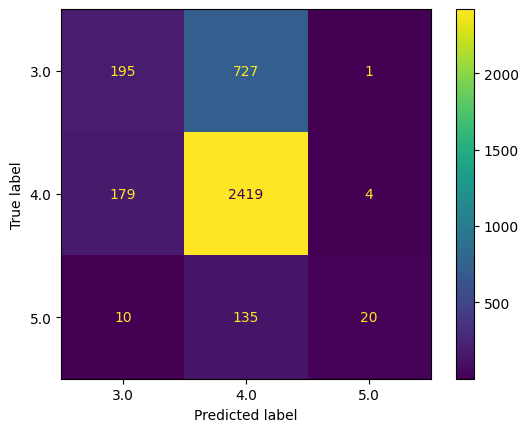

              precision    recall  f1-score   support

         3.0       0.51      0.21      0.30       923
         4.0       0.74      0.93      0.82      2602
         5.0       0.80      0.12      0.21       165

    accuracy                           0.71      3690
   macro avg       0.68      0.42      0.44      3690
weighted avg       0.68      0.71      0.66      3690



In [156]:
base_classifiers = [GaussianNB(),
                    CategoricalNB(alpha=0.8, min_categories = [len(ORD_ENCODER.categories_[i]) for i in range(len(CATEGORICAL_FEATURES))]),
                    MultinomialNB()]

meta_classifier = CategoricalNB()
snb = StackingNB(base_classifiers, meta_classifier)
snb.fit(X_train_oe, y_train)

y_pred = validate_and_test(snb, X_train_oe, y_train, X_val_oe, y_val)

## SVM

In [157]:
from sklearn import svm

### Linear

In [158]:
# First try with Linear SVM
linearSVM = svm.LinearSVC(random_state=30027)
param_grid = {'C': range(1,102,10)}
tune_hyperparameter(linearSVM, param_grid, X_train_ohe, y_train, cv=5)

Fitting 5 folds for each of 11 candidates, totalling 55 fits
[CV] END ................................................C=1; total time=   1.6s
[CV] END ................................................C=1; total time=   1.3s
[CV] END ................................................C=1; total time=   1.4s
[CV] END ................................................C=1; total time=   1.5s
[CV] END ................................................C=1; total time=   1.4s
[CV] END ...............................................C=11; total time=   1.7s
[CV] END ...............................................C=11; total time=   1.5s
[CV] END ...............................................C=11; total time=   1.4s
[CV] END ...............................................C=11; total time=   1.4s
[CV] END ...............................................C=11; total time=   1.4s
[CV] END ...............................................C=21; total time=   1.7s
[CV] END .......................................

,params,mean_test_3.0_f1-score,std_test_3.0_f1-score,rank_test_3.0_f1-score,mean_test_4.0_f1-score,std_test_4.0_f1-score,rank_test_4.0_f1-score,mean_test_5.0_f1-score,std_test_5.0_f1-score,rank_test_5.0_f1-score,mean_test_accuracy,std_test_accuracy,rank_test_accuracy
0,{'C': 1},0.263110,0.026351,7,0.811334,0.002692,1,0.152047,0.036760,1,0.697696,0.002749,1
1,{'C': 11},0.198376,0.118488,9,0.803741,0.036571,2,0.123863,0.039699,9,0.688550,0.032690,2
2,{'C': 21},0.196981,0.152821,10,0.786883,0.055887,3,0.144491,0.040172,5,0.670528,0.051233,3
3,{'C': 31},0.242732,0.157483,8,0.783909,0.044330,4,0.146894,0.055202,3,0.668089,0.039714,4
4,{'C': 41},0.424015,0.017468,1,0.544323,0.176349,11,0.134443,0.061574,8,0.498171,0.092899,11
5,{'C': 51},0.271210,0.134374,5,0.639542,0.229364,9,0.146206,0.013528,4,0.573577,0.162146,9
6,{'C': 61},0.368512,0.125540,2,0.578740,0.194935,10,0.139681,0.049620,7,0.524187,0.123033,10
7,{'C': 71},0.173864,0.133655,11,0.766209,0.113125,5,0.151690,0.055462,2,0.660230,0.087613,5
8,{'C': 81},0.269386,0.154300,6,0.714264,0.128886,6,0.107930,0.029669,11,0.612127,0.103354,6
9,{'C': 91},0.352776,0.124826,3,0.681402,0.097541,8,0.141340,0.024501,6,0.578794,0.084705,8


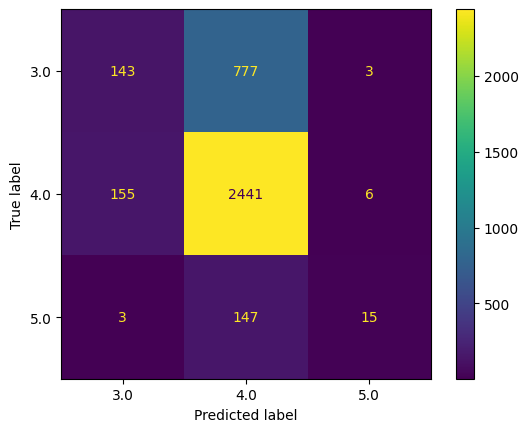

              precision    recall  f1-score   support

         3.0       0.48      0.15      0.23       923
         4.0       0.73      0.94      0.82      2602
         5.0       0.62      0.09      0.16       165

    accuracy                           0.70      3690
   macro avg       0.61      0.39      0.40      3690
weighted avg       0.66      0.70      0.64      3690



array([4., 4., 4., ..., 4., 4., 4.])

In [159]:
linearSVM = svm.LinearSVC(random_state=30027, C=1)
linearSVM.fit(X_train_ohe, y_train)
evaluate(linearSVM, X_val_ohe, y_val)

### Kernel

In [160]:
# Try with Kernel SVM
RBF_svm = svm.SVC(kernel='rbf')

# tune hyperparameter C and gamma
param_grid = {'C': range(1, 101, 20), 'gamma': [0.1, 0.3, 0.5, 0.7, 0.9]}
tune_hyperparameter(RBF_svm, param_grid, X_train_ohe, y_train, cv=2)

Fitting 2 folds for each of 25 candidates, totalling 50 fits
[CV] END .....................................C=1, gamma=0.1; total time=  42.7s
[CV] END .....................................C=1, gamma=0.1; total time=  39.8s
[CV] END .....................................C=1, gamma=0.3; total time=  46.3s
[CV] END .....................................C=1, gamma=0.3; total time=  45.1s
[CV] END .....................................C=1, gamma=0.5; total time=  50.8s
[CV] END .....................................C=1, gamma=0.5; total time=  50.0s
[CV] END .....................................C=1, gamma=0.7; total time=  53.7s
[CV] END .....................................C=1, gamma=0.7; total time=  53.3s
[CV] END .....................................C=1, gamma=0.9; total time=  54.5s
[CV] END .....................................C=1, gamma=0.9; total time=  53.1s
[CV] END ....................................C=21, gamma=0.1; total time=  39.6s
[CV] END ....................................C=2

,params,mean_test_3.0_f1-score,std_test_3.0_f1-score,rank_test_3.0_f1-score,mean_test_4.0_f1-score,std_test_4.0_f1-score,rank_test_4.0_f1-score,mean_test_5.0_f1-score,std_test_5.0_f1-score,rank_test_5.0_f1-score,mean_test_accuracy,std_test_accuracy,rank_test_accuracy
0,"{'C': 1, 'gamma': 0.1}",0.035948,0.009019,25,0.825757,0.000205,1,0.055882,0.006038,17,0.704946,0.000745,3
1,"{'C': 1, 'gamma': 0.3}",0.121188,0.010342,24,0.824531,0.000447,2,0.055617,0.011867,18,0.706775,0.000000,1
2,"{'C': 1, 'gamma': 0.5}",0.150050,0.010450,22,0.823025,0.002294,3,0.037326,0.000174,23,0.705827,0.002575,2
3,"{'C': 1, 'gamma': 0.7}",0.150505,0.011013,21,0.821354,0.002328,4,0.018790,0.006132,25,0.703388,0.002575,4
4,"{'C': 1, 'gamma': 0.9}",0.146003,0.012239,23,0.820207,0.002287,5,0.021797,0.003047,24,0.701423,0.002507,5
5,"{'C': 21, 'gamma': 0.1}",0.293541,0.001291,12,0.796590,0.002540,10,0.137516,0.017097,1,0.680081,0.002981,6
6,"{'C': 21, 'gamma': 0.3}",0.315049,0.002979,1,0.776382,0.000887,20,0.124116,0.001185,5,0.657182,0.000542,20
7,"{'C': 21, 'gamma': 0.5}",0.298257,0.001260,11,0.783030,0.001749,18,0.088602,0.002307,9,0.663144,0.001762,19
8,"{'C': 21, 'gamma': 0.7}",0.275162,0.004386,16,0.791460,0.000921,14,0.057998,0.004665,13,0.671070,0.000474,14
9,"{'C': 21, 'gamma': 0.9}",0.247410,0.001859,17,0.798489,0.001442,6,0.041837,0.002731,19,0.677642,0.001762,7


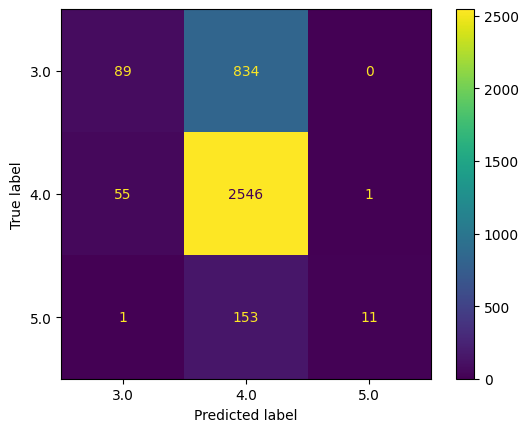

              precision    recall  f1-score   support

         3.0       0.61      0.10      0.17       923
         4.0       0.72      0.98      0.83      2602
         5.0       0.92      0.07      0.12       165

    accuracy                           0.72      3690
   macro avg       0.75      0.38      0.37      3690
weighted avg       0.70      0.72      0.63      3690



array([4., 4., 4., ..., 4., 4., 4.])

In [164]:
RBF_svm = svm.SVC(kernel='rbf', gamma=0.3, C=1)
RBF_svm.fit(X_train_ohe, y_train)
evaluate(RBF_svm, X_val_ohe, y_val)
# Kernel SVM performs slightly better on weighted avg precision & recall than Linear SVM

## Logistic Regression

In [162]:
from sklearn.linear_model import LogisticRegression

logr = LogisticRegression(solver='sag') # uses Stochastic Average Gradient descent solver

In [165]:
param_grid = {'max_iter': [100, 500, 1000, 5000, 10000]}
cv_results = tune_hyperparameter(logr, param_grid, X_train_ohe, y_train, cv=3)
cv_results
# max_iter>=500 works well

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END .......................................max_iter=100; total time=  13.1s
[CV] END .......................................max_iter=100; total time=  12.9s
[CV] END .......................................max_iter=100; total time=  12.9s
[CV] END .......................................max_iter=500; total time=  26.1s
[CV] END .......................................max_iter=500; total time=  24.8s
[CV] END .......................................max_iter=500; total time=  26.3s
[CV] END ......................................max_iter=1000; total time=  25.9s
[CV] END ......................................max_iter=1000; total time=  24.7s
[CV] END ......................................max_iter=1000; total time=  26.9s
[CV] END ......................................max_iter=5000; total time=  26.3s
[CV] END ......................................max_iter=5000; total time=  24.6s
[CV] END ......................................ma

,params,mean_test_3.0_f1-score,std_test_3.0_f1-score,rank_test_3.0_f1-score,mean_test_4.0_f1-score,std_test_4.0_f1-score,rank_test_4.0_f1-score,mean_test_5.0_f1-score,std_test_5.0_f1-score,rank_test_5.0_f1-score,mean_test_accuracy,std_test_accuracy,rank_test_accuracy
0,{'max_iter': 100},0.237972,0.007643,5,0.816762,0.004673,1,0.096348,0.021752,1,0.702642,0.006421,1
1,{'max_iter': 500},0.238580,0.007874,1,0.816681,0.004679,2,0.096162,0.021501,2,0.702575,0.006447,2
2,{'max_iter': 1000},0.238580,0.007874,1,0.816681,0.004679,2,0.096162,0.021501,2,0.702575,0.006447,2
3,{'max_iter': 5000},0.238580,0.007874,1,0.816681,0.004679,2,0.096162,0.021501,2,0.702575,0.006447,2
4,{'max_iter': 10000},0.238580,0.007874,1,0.816681,0.004679,2,0.096162,0.021501,2,0.702575,0.006447,2


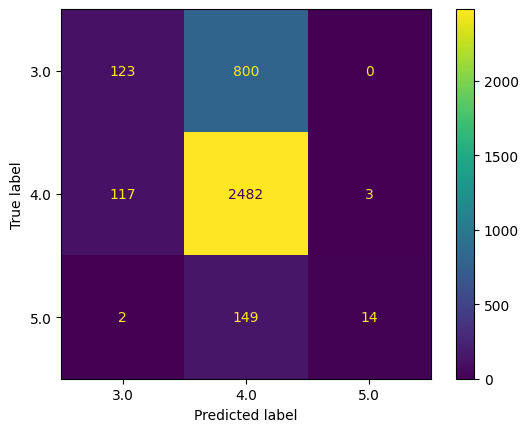

              precision    recall  f1-score   support

         3.0       0.51      0.13      0.21       923
         4.0       0.72      0.95      0.82      2602
         5.0       0.82      0.08      0.15       165

    accuracy                           0.71      3690
   macro avg       0.69      0.39      0.40      3690
weighted avg       0.67      0.71      0.64      3690



array([4., 4., 4., ..., 4., 4., 4.])

In [171]:
logr = LogisticRegression(solver='sag', max_iter=100)
logr.fit(X_train_ohe, y_train)
evaluate(logr, X_val_ohe, y_val)

## Boosting

In [167]:
from sklearn.ensemble import HistGradientBoostingClassifier

hgb = HistGradientBoostingClassifier(random_state=30027)

In [168]:
# Tuning using GridSearch
param_grid = {
    'learning_rate': (0.01, 0.1, 1, 10),
    'max_leaf_nodes': (3, 10, 30)}
cv_results = tune_hyperparameter(hgb, param_grid, X_train_oe, y_train, cv=5)
cv_results
# 'Best' param set: learning_rate = 0.1, max_leaf_nodes = 10

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END ...............learning_rate=0.01, max_leaf_nodes=3; total time=   3.0s
[CV] END ...............learning_rate=0.01, max_leaf_nodes=3; total time=   2.8s
[CV] END ...............learning_rate=0.01, max_leaf_nodes=3; total time=   2.7s
[CV] END ...............learning_rate=0.01, max_leaf_nodes=3; total time=   2.7s
[CV] END ...............learning_rate=0.01, max_leaf_nodes=3; total time=   2.7s
[CV] END ..............learning_rate=0.01, max_leaf_nodes=10; total time=   4.9s
[CV] END ..............learning_rate=0.01, max_leaf_nodes=10; total time=   4.9s
[CV] END ..............learning_rate=0.01, max_leaf_nodes=10; total time=   5.0s
[CV] END ..............learning_rate=0.01, max_leaf_nodes=10; total time=   4.9s
[CV] END ..............learning_rate=0.01, max_leaf_nodes=10; total time=   4.6s
[CV] END ..............learning_rate=0.01, max_leaf_nodes=30; total time=   8.0s
[CV] END ..............learning_rate=0.01, max_l

,params,mean_test_3.0_f1-score,std_test_3.0_f1-score,rank_test_3.0_f1-score,mean_test_4.0_f1-score,std_test_4.0_f1-score,rank_test_4.0_f1-score,mean_test_5.0_f1-score,std_test_5.0_f1-score,rank_test_5.0_f1-score,mean_test_accuracy,std_test_accuracy,rank_test_accuracy
0,"{'learning_rate': 0.01, 'max_leaf_nodes': 3}",0.000000,0.000000,12,0.824139,0.000148,1,0.000000,0.000000,11,0.700881,0.000214,4
1,"{'learning_rate': 0.01, 'max_leaf_nodes': 10}",0.013006,0.002300,11,0.824008,0.001090,2,0.031300,0.019725,5,0.701355,0.001598,3
2,"{'learning_rate': 0.01, 'max_leaf_nodes': 30}",0.034125,0.004800,8,0.823943,0.001111,3,0.040578,0.015724,4,0.702033,0.001626,2
3,"{'learning_rate': 0.1, 'max_leaf_nodes': 3}",0.017018,0.009084,10,0.823548,0.000691,4,0.025003,0.012256,7,0.700813,0.001080,5
4,"{'learning_rate': 0.1, 'max_leaf_nodes': 10}",0.055504,0.015351,7,0.823305,0.001064,5,0.064407,0.005982,3,0.702100,0.001260,1
5,"{'learning_rate': 0.1, 'max_leaf_nodes': 30}",0.089653,0.021361,6,0.820949,0.001415,7,0.069391,0.006312,2,0.700271,0.002114,6
6,"{'learning_rate': 1, 'max_leaf_nodes': 3}",0.028920,0.020729,9,0.822252,0.001010,6,0.005714,0.011429,10,0.698442,0.001080,7
7,"{'learning_rate': 1, 'max_leaf_nodes': 10}",0.097987,0.025045,5,0.809339,0.005044,8,0.025965,0.017583,6,0.682453,0.006828,8
8,"{'learning_rate': 1, 'max_leaf_nodes': 30}",0.168366,0.024302,4,0.784774,0.003908,9,0.089979,0.027399,1,0.652304,0.004399,9
9,"{'learning_rate': 10, 'max_leaf_nodes': 3}",0.250257,0.002555,1,0.602914,0.017618,11,0.000000,0.000000,11,0.472290,0.014607,11


In [173]:
# 2nd go
hgb = HistGradientBoostingClassifier(random_state=30027, learning_rate=0.1)
param_grid = {
    'max_leaf_nodes': range(10, 30, 2)}
cv_results = tune_hyperparameter(hgb, param_grid, X_train_oe, y_train, cv=5)
cv_results
# 'Best' param set: learning_rate = 0.01, max_leaf_nodes = 10

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END ..................................max_leaf_nodes=10; total time=   2.9s
[CV] END ..................................max_leaf_nodes=10; total time=   2.3s
[CV] END ..................................max_leaf_nodes=10; total time=   2.2s
[CV] END ..................................max_leaf_nodes=10; total time=   3.0s
[CV] END ..................................max_leaf_nodes=10; total time=   1.2s
[CV] END ..................................max_leaf_nodes=12; total time=   2.4s
[CV] END ..................................max_leaf_nodes=12; total time=   2.1s
[CV] END ..................................max_leaf_nodes=12; total time=   2.5s
[CV] END ..................................max_leaf_nodes=12; total time=   2.7s
[CV] END ..................................max_leaf_nodes=12; total time=   1.6s
[CV] END ..................................max_leaf_nodes=14; total time=   2.1s
[CV] END ..................................max_l

,params,mean_test_3.0_f1-score,std_test_3.0_f1-score,rank_test_3.0_f1-score,mean_test_4.0_f1-score,std_test_4.0_f1-score,rank_test_4.0_f1-score,mean_test_5.0_f1-score,std_test_5.0_f1-score,rank_test_5.0_f1-score,mean_test_accuracy,std_test_accuracy,rank_test_accuracy
0,{'max_leaf_nodes': 10},0.055504,0.015351,10,0.823305,0.001064,2,0.064407,0.005982,4,0.702100,0.001260,4
1,{'max_leaf_nodes': 12},0.057029,0.016090,9,0.823384,0.001492,1,0.061259,0.009668,8,0.702304,0.002241,2
2,{'max_leaf_nodes': 14},0.061589,0.015331,7,0.822821,0.001470,6,0.067160,0.007284,1,0.701694,0.002392,8
3,{'max_leaf_nodes': 16},0.059416,0.012970,8,0.823273,0.001077,3,0.064290,0.011235,5,0.702168,0.001897,3
4,{'max_leaf_nodes': 18},0.068701,0.022365,6,0.822849,0.000749,5,0.067025,0.006941,2,0.701965,0.001310,5
5,{'max_leaf_nodes': 20},0.076730,0.023936,3,0.822521,0.001568,7,0.060923,0.009361,10,0.701829,0.002114,6
6,{'max_leaf_nodes': 22},0.074698,0.013135,5,0.822959,0.001174,4,0.061036,0.013051,9,0.702371,0.002313,1
7,{'max_leaf_nodes': 24},0.076548,0.022921,4,0.821810,0.001185,10,0.064039,0.006199,7,0.700881,0.001421,10
8,{'max_leaf_nodes': 26},0.082243,0.027390,2,0.822210,0.001365,9,0.066954,0.012004,3,0.701694,0.001204,8
9,{'max_leaf_nodes': 28},0.083076,0.018842,1,0.822330,0.000784,8,0.064092,0.010712,6,0.701762,0.001105,7


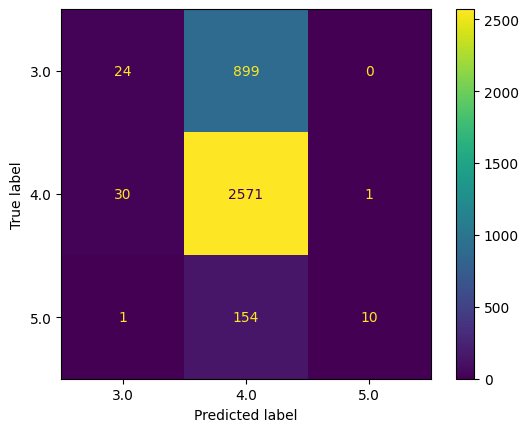

              precision    recall  f1-score   support

         3.0       0.44      0.03      0.05       923
         4.0       0.71      0.99      0.83      2602
         5.0       0.91      0.06      0.11       165

    accuracy                           0.71      3690
   macro avg       0.68      0.36      0.33      3690
weighted avg       0.65      0.71      0.60      3690



array([4., 4., 4., ..., 4., 4., 4.])

In [181]:
hgb = HistGradientBoostingClassifier(random_state=30027, max_leaf_nodes=22, learning_rate=0.1)
hgb.fit(X_train_oe, y_train)
evaluate(hgb, X_val_oe, y_val)

## Baseline - 0R & 1R

In [174]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier

Evaluate on training set:

DummyClassifier prediction took 0.27190709114074707 seconds
test_3.0_f1-score    0.000000
test_4.0_f1-score    0.824185
test_5.0_f1-score    0.000000
test_accuracy        0.700949
dtype: float64


Evaluate on validation set:



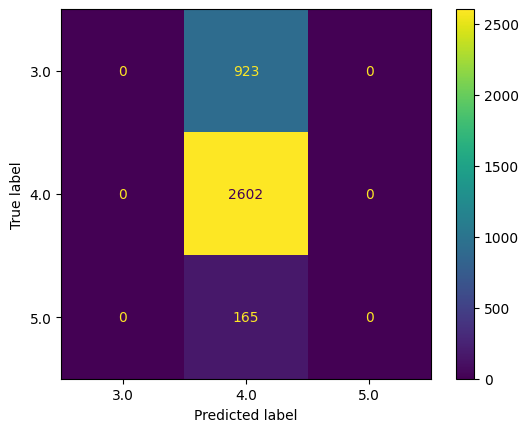

              precision    recall  f1-score   support

         3.0       0.00      0.00      0.00       923
         4.0       0.71      1.00      0.83      2602
         5.0       0.00      0.00      0.00       165

    accuracy                           0.71      3690
   macro avg       0.24      0.33      0.28      3690
weighted avg       0.50      0.71      0.58      3690



array([4., 4., 4., ..., 4., 4., 4.])

In [175]:
# 0R
zero_r = DummyClassifier(strategy='most_frequent')
validate_and_test(zero_r, X_train, y_train, X_val, y_val, print_full_cv_results=False)

Evaluate on training set:

DecisionTreeClassifier prediction took 0.7910501956939697 seconds
test_3.0_f1-score    0.000000
test_4.0_f1-score    0.824185
test_5.0_f1-score    0.000000
test_accuracy        0.700949
dtype: float64


Evaluate on validation set:



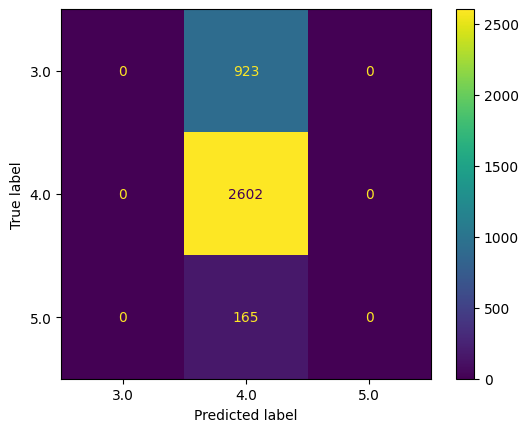

              precision    recall  f1-score   support

         3.0       0.00      0.00      0.00       923
         4.0       0.71      1.00      0.83      2602
         5.0       0.00      0.00      0.00       165

    accuracy                           0.71      3690
   macro avg       0.24      0.33      0.28      3690
weighted avg       0.50      0.71      0.58      3690



array([4., 4., 4., ..., 4., 4., 4.])

In [176]:
# 1R
one_r = DecisionTreeClassifier(max_depth=1)
validate_and_test(one_r, X_train_oe, y_train, X_val_oe, y_val, print_full_cv_results=False)

# 3. Final predictions on the test set

In [179]:
X_test_ohe = ohe_transform(test_df)
X_test_oe = ord_enc_transform(test_df)

In [180]:
model_sets = {snb: X_test_oe, RBF_svm: X_test_ohe, logr: X_test_ohe, hgb: X_test_oe}
y_test_preds = []
for model in model_sets:
    y_test_pred = model.predict(model_sets[model])
    y_test_preds.append(y_test_pred)


In [182]:
y_test_preds

[array([4., 4., 4., ..., 4., 4., 4.]),
 array([4., 4., 4., ..., 4., 4., 4.]),
 array([4., 4., 4., ..., 4., 4., 4.]),
 array([4., 4., 4., ..., 4., 4., 4.])]